In [2]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [3]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/supp_figure_stable_recording'
# figdir_supp = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis/supp'
misc.get_or_create_subdir(figdir)
# misc.get_or_create_subdir(figdir_supp)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [4]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
import matplotlib
matplotlib.rcParams['svg.fonttype']='none'
matplotlib.rcParams['font.size']=10

In [6]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']
fr_map_trial_df_pyr_combined_all = prepped_data_agg['fr_map_trial_df_pyr_combined_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']
pf_params_all = prepped_data_agg['pf_params_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [7]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

In [8]:
data_dir_full = subdb.iloc[0]['data_dir_full']
ani=subdb.iloc[0]['animal_name.1']
sess=subdb.iloc[0]['sess_name']

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
# behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
# beh_df = prep_res['beh_df'].as_dataframe()
# beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

ripples = mat_to_return['ripples']
ripple_events = ripples

cell_metrics=mat_to_return.cell_metrics
mergepoints = mat_to_return.mergepoints

cell_type_mask=mat_to_return['cell_type_mask']

load *SessionPulses.Events.mat failed


In [12]:
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913'

In [ ]:
cell

In [9]:
import glob
spikes=glob.glob(os.path.join(data_dir_full,'*spikes.cellinfo.mat'))[0]
spikes = dpn.loadmat_full(spikes,'spikes')

In [10]:
mergepoints['timestamps']

array([[    0.        ,  7845.98396667],
       [ 7845.984     , 10023.71196667],
       [10023.712     , 16561.95196667]])

In [38]:
cell_type_mask

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [11]:
import pynapple as nap

In [12]:
pre_post = nap.IntervalSet(start=mergepoints['timestamps'][[0,2],0],end=mergepoints['timestamps'][[0,2],1])

In [13]:
spk_times = spikes.times
spk_amp = spikes.amplitudes
uid_l = cell_metrics['UID']
epoch_l =mergepoints['timestamps']
ep_row_d = {'pre':0,'post':2}
amp_all ={}
for ii, spk in enumerate(spk_times):
    uid = uid_l[ii]
    amp_one_d = {}
    for ep_key,ep_row in ep_row_d.items():
        st,ed = epoch_l[ep_row]
        spk_ma = (spk >=st)&(spk <=ed)
        spk_amp_left = spk_amp[ii][spk_ma] 
        amp_one = pd.Series({'mean':np.mean(spk_amp_left),'std':np.std(spk_amp_left)})
        amp_one_d[ep_key] = amp_one
    amp_one_d = pd.concat(amp_one_d)
    amp_all[uid] = amp_one_d

amp_all = pd.concat(amp_all)
amp_all = amp_all.unstack(level=(-1,-2))
    
amp_all_mean = amp_all['mean']

    
    


        
        

In [14]:
gpb=all_sw_with_metrics_d_all.loc[ani,sess,0].groupby('uid')

uid_category_all = {}

key_l = np.array(['ON only','OFF only','Both','No switch'])
for uid in cell_cols_d['pyr']:
    has_on=False
    has_off=False
    has_both=False
    has_on_only=False
    has_off_only=False
    no_switch = True
    if uid in gpb.groups.keys():
        val = gpb.get_group(uid)
        if 1 in val['switch'].values:
            has_on = True
            no_switch = False
        if -1 in val['switch'].values:
            has_off = True
            no_switch=False
        if has_on and has_off:
            has_both = True
        if has_on and not has_off:
            has_on_only=True
        if not has_on and has_off:
            has_off_only=True
    
    cat = key_l[np.array([has_on_only,has_off_only,has_both,no_switch])][0] 
#     uid_category = {'ON only':has_on_only,'OFF only':has_off_only,'Both':has_both,'No switch':no_switch}
#     uid_category_all[uid] = uid_category
    uid_category_all[uid] = cat
# uid_category_all = pd.DataFrame(uid_category_all).T
uid_category_all = pd.Series(uid_category_all)
    

/tmp/ipykernel_1449681/2007292034.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  gpb=all_sw_with_metrics_d_all.loc[ani,sess,0].groupby('uid')


In [15]:
amp_all_mean['category'] = uid_category_all
amp_all_mean=amp_all_mean.dropna(axis=0)

/tmp/ipykernel_1449681/2915292239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amp_all_mean['category'] = uid_category_all


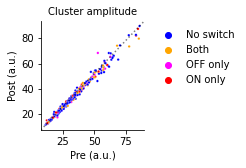

In [18]:
fig,ax=plt.subplots(figsize=(2,2))
ax.set_aspect('equal')
# for col in uid_category_all.columns:
#     ma=uid_category_all[col]
#     ax.scatter(amp_all_mean['pre'],amp_all_mean['post'])
palette = {'ON only':'red','OFF only':'magenta','Both':'orange','No switch':'blue'}
sns.scatterplot(data=amp_all_mean,x='pre',y='post',hue='category',s=6,palette=palette,ax=ax)
ax.plot([0,1],[0,1],transform=ax.transAxes,c='k',linestyle=':',alpha=0.5)
ax.legend(title='',bbox_to_anchor=[1.05,1],frameon=False)
# ax.set_xlim([0,80])
# ax.set_ylim([0,80])
# ax.set_xticks([0,50])
# ax.set_yticks([0,50])
ax.set_title(u'Cluster amplitude')
ax.set_xlabel('Pre (a.u.)')
ax.set_ylabel('Post (a.u.)')
sns.despine()

figfn = f'waveform_amp_post_vs_pre_{sess}'
ph.save_given_name(fig,figfn,figdir)

In [19]:
amp_all_mean['diff'] = amp_all_mean['post'] - amp_all_mean['pre']

In [20]:
scipy.stats.ranksums(amp_all_mean.loc[amp_all_mean['category']=='No switch']['diff'],
amp_all_mean.loc[amp_all_mean['category']=='ON only']['diff'])


RanksumsResult(statistic=0.39460108677225997, pvalue=0.6931373113604358)

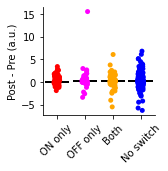

In [21]:
fig,ax=plt.subplots(figsize=(2,2))
sns.stripplot(data=amp_all_mean,x='category',y='diff',palette=palette,ax=ax,order=key_l)
sns.boxplot(data=amp_all_mean,x='category',y='diff',palette=palette,ax=ax,order=key_l,
            medianprops=dict(color="k", linewidth=2),
            boxprops=dict(visible=False),
            whiskerprops=dict(visible=False),
            capprops=dict(visible=False),
            flierprops=dict(visible=False))
           
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_xlabel('')
ax.set_ylabel(u'Post - Pre (a.u.)')



figfn = f'waveform_amp_post_minus_pre_boxplot_{sess}'
ph.save_given_name(fig,figfn,figdir)

# example ratemaps

In [239]:
ind_l = [
    ('e15_13f1','e15_13f1_220117',0,0,32,1),
    ('e15_13f1','e15_13f1_220117',0,1,323,0),
    ('e15_13f1','e15_13f1_220117',0,0,73,1),
]

/tmp/ipykernel_1297660/4048236999.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap = fr_map_trial_df_all.loc[(ani,sess,ti,tt,uid),:].dropna(axis=1).T
/mnt/home/szheng/projects/util_code/plot_helper.py:575: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/tmp/ipykernel_1297660/4048236999.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap = fr_map_trial_df_all.loc[(ani,sess,ti,tt,uid),:].dropna(axis=1).T
/mnt/home/szheng/projects/util_code/plot_helper.py:575: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/tmp/ipykernel_1297660/4048236999.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap = fr_map_trial_df_all.loc[(ani,sess,ti,tt,uid),:].dropna(axis=1).T
/mnt/home/szheng/projects/util_code/plot_helper.py:575: UserWarning: FixedFormatt

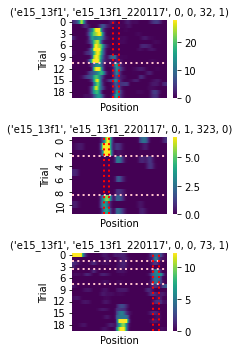

In [264]:
fig,axs=plt.subplots(3,1,figsize=(2.5,5),sharex=True)
for ii,ind in enumerate(ind_l):
    ax=axs[ii]
    ani,sess,ti,tt,uid,field_id = ind
    frmap = fr_map_trial_df_all.loc[(ani,sess,ti,tt,uid),:].dropna(axis=1).T
    field_bound=all_fields_recombined_all.loc[ani,sess,ti,tt,uid,field_id][['start','end']]
    all_sw_d_all_indset=all_sw_d_all.set_index(['trialtype','uid','field_index'],append=True)
    ind_within=all_sw_d_all_indset.loc[(ani,sess,ti,slice(None),tt,uid,field_id),:]['index_within']
    ph.ratemap_one_raw(frmap,heatmap_kws={'vmax_quantile':0.99},field_bound=field_bound,trial=ind_within,fig=fig,ax=ax)
    ax.set_xticks([])
    ax.set_ylabel('Trial')
#     figfn = f'ex_{ind}'
    ax.set_title(ind)
figfn = 'ex_ratemaps'
plt.tight_layout()
ph.save_given_name(fig,figfn,figdir)


/tmp/ipykernel_1297660/4027093945.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df_all.loc[(ani,sess,ti,tt,uid),:].dropna(axis=1).T


,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,13.563495,15.448069,18.122520,20.512023,22.090894,22.654123,22.006164,19.880189,16.228900,11.781260,...,3.556270,3.218498,2.855171,2.442196,1.950632,1.398273,0.864049,0.447453,0.195961,0.088269
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.597932,1.628727,1.057497,0.763011,0.615711,0.521288,0.424677,0.310711,0.201263,0.133944
2,1.592374,1.479623,1.308157,1.119966,0.929586,0.740223,0.554272,0.377719,0.222788,0.107365,...,0.935726,0.539039,0.255193,0.096113,0.027972,0.006336,0.001177,0.000192,0.000000,0.000000
3,1.292453,1.013809,0.695587,0.451285,0.284321,0.174973,0.105104,0.061311,0.034250,0.017868,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.581552,2.313761,1.352806,0.731679,0.367616,0.169315,0.069751,0.024883,0.007332,0.002346
5,0.227010,0.275361,0.336425,0.378968,0.392832,0.379605,0.342808,0.286498,0.223055,0.189427,...,5.676789,5.930604,6.114831,5.985595,5.210331,3.697403,2.006810,0.847024,0.303282,0.118322
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.324276,3.662301,2.708902,1.756043,1.011491,0.522694,0.242141,0.099523,0.036150,0.013639
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.617004,3.139156,2.657064,2.134777,1.561032,0.986958,0.516026,0.219099,0.077507,0.028131
8,0.615567,0.557351,0.450950,0.323663,0.208444,0.123124,0.067817,0.034901,0.016506,0.006829,...,0.899458,0.746493,0.855688,1.239590,1.806232,2.393021,2.849905,3.116581,3.229938,3.261440
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000192,0.000960,0.004422,0.018069,0.061006,...,0.003094,0.000744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [86]:
amp_all

,mean,std,mean,std
,pre,pre,post,post
1.0,45.199549,4.481522,46.455038,5.397171
2.0,46.800137,4.369409,46.980769,4.746704
3.0,33.533068,2.973324,34.962935,4.235491
4.0,19.224958,2.302917,19.168699,2.444820
5.0,19.662589,2.466472,19.463335,2.566618
...,...,...,...,...
478.0,30.498743,7.218785,30.690157,7.427221
479.0,49.903797,8.747121,49.261990,8.999922
480.0,56.973580,7.443418,58.517208,8.520998


In [73]:
spk

array([9.56666667e-02, 4.90633333e-01, 9.27066667e-01, ...,
       1.65584501e+04, 1.65589115e+04, 1.65602760e+04])

In [23]:
spikes.amplitudes[0].shape

(733,)

In [28]:
spikes.amplitudes[4].shape

(429493,)